In [1]:
import numpy as np
import tensorflow as tf
import os
import random
import sys
import argparse
import csv
from glob import glob
import pickle
import gzip
import scipy
import pandas as pd
import keras
import keras.layers as layers
from keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from time import time
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
random.seed(432)

Using TensorFlow backend.


Numpy version: 1.18.1
Tensorflow version: 2.3.0
Keras version: 2.3.1


Using TensorFlow backend.

Numpy version: 1.18.1

Tensorflow version: 2.3.0

Keras version: 2.3.1

In [2]:
import h5py
import pandas as pd
import layers as layers
import models as models

In [4]:
TRAIN_DIR = #PATH to EyePACS train
TEST_DIR = #PATH to EyePACS test
MESSIDOR2_DIR = #PATH

In [5]:
batch_size = 8

def preprocessing(image):
    image = tf.image.random_brightness(image, 0.125)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    return image

datagen = ImageDataGenerator(
                                samplewise_center = True,
                                horizontal_flip=True,
                                rescale=1./255,
                                preprocessing_function = preprocessing,
                                validation_split=0.2
                                )

datagen_val = ImageDataGenerator(
                                samplewise_center = True,
                                rescale=1./255,
                                )

In [6]:
train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(299, 299),  
    color_mode='rgb',
    batch_size=8,
    class_mode='sparse',
    subset='training',
    #shuffle=True
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),  
    color_mode='rgb',
    batch_size=8,
    class_mode='sparse',
    subset='validation',
    #shuffle=False
)

Found 45464 images belonging to 5 classes.
Found 11363 images belonging to 5 classes.


In [7]:
input_tensor = Input(shape=(299, 299,3))  # this assumes K.image_data_format() == 'channels_last'
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling='avg')
# add a global spatial average pooling layer
x = base_model.output
x = Dense(2048, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

#for layer in base_model.layers:
#    layer.trainable = False

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
def loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true/4, y_pred[:,0:1]) + 0.6067946695606887 * y_pred[:, 1:2]

model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=7.627543070640397e-05)) #Warming up

In [9]:
model.load_weights('/home/stoledoc/work/data2/jama16-retina-replication-master/inceptionV3_keras_2_2.h5') #Weights from https://github.com/stoledoc/DLGP-DR-Diagnosis

In [11]:
layer_name = 'global_average_pooling2d'
intermediate_layer_model = tf.keras.Model(inputs = model.input, outputs = model.get_layer(layer_name).output)

In [14]:
for layer in intermediate_layer_model.layers:
    layer.trainable = False

In [9]:
#QMR model layers set up

fm_x = layers.QFeatureMapRFF(
                            input_dim=2048,
                            dim=128, 
                            gamma=0.0005246109836455565, 
                            random_state=17)
qm = layers.QMeasureClassifEigF(dim_x=128, dim_y=5, num_eig=8)
dmregress = layers.DensityMatrixRegression()

psi_x = fm_x(intermediate_layer_model.output)
rho_y = qm(psi_x)
output = dmregress(rho_y)

qmr_layer_model = tf.keras.Model(inputs = intermediate_layer_model.input, outputs = output)
qmr_layer_model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=7.627543070640397e-05))

In [15]:
qmr_layer_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
filepath = "warming_up_saved-model_inception+qmr_v2-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = False, mode = 'min')
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           verbose=0, 
                           mode='min',  
                           restore_best_weights=True)
history = qmr_layer_model.fit_generator(train_generator,
                    steps_per_epoch = 45464 // batch_size,
                    epochs = 60,
                    validation_data = val_generator,
                    validation_steps =  11363 // batch_size,
                    callbacks = [checkpoint, early_stop],
                    #shuffle=True
                   )

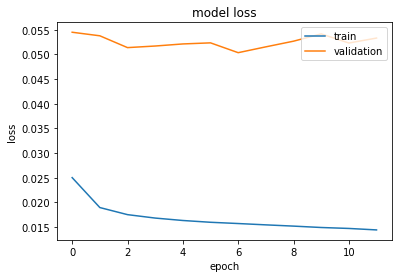

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Listo el warming up, ahora el full training

In [21]:
qmr_layer_model.load_weights('/home/stoledoc/work/data2/Kaggle_Paper_binary/DR+QMR/full_train_saved-model_inception+qmr-14-0.0371.h5', by_name = True)

In [17]:
filepath = "full_train_saved-model_inception+qmr-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = False, mode = 'min')

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           verbose=0, 
                           mode='min',  
                           restore_best_weights=True)

# train the full model

history = qmr_layer_model.fit_generator(train_generator,
                    steps_per_epoch = 45463 // batch_size,
                    epochs = 100,
                    validation_data = val_generator,
                    validation_steps = 11364 // batch_size,
                    callbacks = [checkpoint, early_stop],
                    shuffle=True
                   )

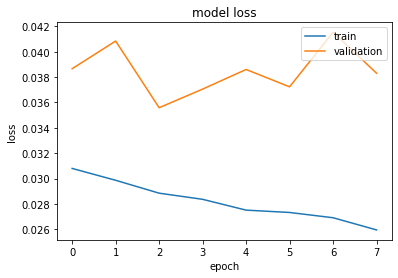

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Keras Test

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [16]:
qmr_layer_model.load_weights('/home/stoledoc/work/data2/Kaggle_Paper_binary/DR+QMR/full_train_saved-model_inception+qmr-03-0.0356.h5', by_name = True)

In [17]:
data_dir = '/home/stoledoc/work/data2/jama16-retina-replication-master/data_2/eyepacs/test_3/' # path to the directory where the images are stored
#index =  0 # select a number here

y_preds = []
y_trues = []
stds = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='sparse',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(8790):
    image, y_true = gen._get_batches_of_transformed_samples(np.array([i]))
    prediction = qmr_layer_model.predict(image)
    y_pred = prediction[:,0]
    std = prediction[:,1]
    y_preds.append(y_pred)
    y_trues.append(y_true)
    stds.append(std)
    
y_trues = np.asarray(y_trues)
y_trues = np.reshape(y_trues, (8790,))

y_preds = np.asarray(y_preds)
y_preds = np.reshape(y_preds, (8790,))

std = np.asarray(stds)
std = np.reshape(std, (8790,))

Found 8790 images belonging to 5 classes.


In [19]:
from sklearn.metrics import mean_absolute_error
print('------------MAE =', mean_absolute_error(y_trues, np.rint(y_preds*4)))

------------MAE = 0.28714448


In [20]:
y_trues

array([0., 0., 0., ..., 4., 4., 4.], dtype=float32)

In [21]:
np.rint(y_preds*4)

array([0., 0., 0., ..., 2., 3., 3.], dtype=float32)

In [23]:
from numpy import savetxt
savetxt('/home/stoledoc/work/data2/predictions_DQOR_Kaggle_test.csv', y_preds, delimiter = ',')

In [22]:
from sklearn.metrics import mean_absolute_error
print('------------MAE =', mean_absolute_error(y_trues, np.rint(y_preds*4)))

------------MAE = 0.28714448


## Binaryzing the results

### Looking at the actual QMR prediction using the expected value

In [26]:
binary_true = np.ones(8790)*9

for i in range(8790):
    if y_trues[i] == 0 or y_trues[i] == 1:
        binary_true[i] = 0.0
    else:
        binary_true[i] = 1.0
        
binary_true = np.reshape(binary_true, (8790,))
binary_true = np.float32(binary_true)

In [27]:
np.count_nonzero(binary_true==0)

8096

In [28]:
binary_pred = np.ones(8790)*2

threshold = (np.mean(y_preds[0:8096])+np.mean(y_preds[8096:8790]))/2
print('Threshold = ', threshold)

for i in range(8790) :
    if y_preds[i] > 0.375:#threshold:
        binary_pred[i] = 1.
    else:
        binary_pred[i] = 0.

Threshold =  0.3413407504558563


In [29]:
print(confusion_matrix(binary_true, binary_pred))

target_names = ['non-referable', 'referable']
print(classification_report(binary_true, binary_pred, target_names=target_names))

[[7941  155]
 [  93  601]]
               precision    recall  f1-score   support

non-referable       0.99      0.98      0.98      8096
    referable       0.79      0.87      0.83       694

     accuracy                           0.97      8790
    macro avg       0.89      0.92      0.91      8790
 weighted avg       0.97      0.97      0.97      8790



In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
y_prob = y_preds - y_preds.min()
y_prob = y_prob/y_prob.max()

fpr, tpr, _ = roc_curve(binary_true, y_prob)
#fpr, tpr, _ = roc_curve(y_vali, y_score)
roc_auc = auc(fpr, tpr)

print('AUC = ', roc_auc)

AUC =  0.9805758491758835


# Uncertainty 

In [32]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [33]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.0, 5.0]
   }
plt.rcParams.update(params)

In [34]:
diferencia = np.absolute((y_trues - np.rint(y_preds*4)).reshape((8790, )))

std_0 = std[np.where(diferencia == 0)]
std_1 = std[np.where(diferencia == 1)]
std_2 = std[np.where(diferencia == 2)]
std_3 = std[np.where(diferencia == 3)]
std_4 = std[np.where(diferencia == 4)]


mean_0 = np.mean(std_0, axis = 0)
std_dif_0 = np.std(std_0, axis = 0)

mean_1 = np.mean(std_1, axis = 0)
std_dif_1 = np.std(std_1, axis = 0)
mean_2 = np.mean(std_2, axis = 0)
std_dif_2 = np.std(std_2, axis = 0)
mean_3 = np.mean(std_3, axis = 0)
std_dif_3 = np.std(std_3, axis = 0)
mean_4 = np.mean(std_4, axis = 0)
std_dif_4 = np.std(std_4, axis = 0)

In [35]:
std_0 = reject_outliers(std_0, m=2)
std_1 = reject_outliers(std_1, m=2)
std_2 = reject_outliers(std_2, m=2)
std_3 = reject_outliers(std_3, m=2)
std_4 = reject_outliers(std_4, m=2)

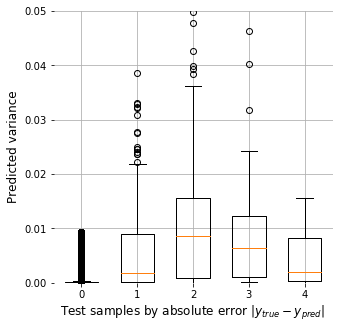

In [36]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([std_0, std_1, std_2, std_3, std_4], widths = 0.6)
plt.ylim(0.00, 0.05)
plt.xticks([1,2,3,4,5], [ '0', '1','2','3','4'])
plt.ylabel('Predicted variance')
plt.xlabel('Test samples by absolute error $|y_{true} - y_{pred}|$')
plt.show()

In [37]:
diferencia = np.absolute((binary_true - binary_pred).reshape((8790, )))

In [38]:
std_0 = std[np.where(diferencia == 0)]
std_1 = std[np.where(diferencia == 1)]

mean_0 = np.mean(std_0, axis = 0)
std_dif_0 = np.std(std_0, axis = 0)

mean_1 = np.mean(std_1, axis = 0)
std_dif_1 = np.std(std_1, axis = 0)

In [39]:
std_0 = reject_outliers(std_0, m=2)
std_1 = reject_outliers(std_1, m=2)

In [40]:
plt.style.use('fivethirtyeight')

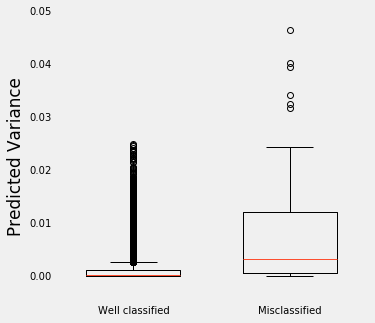

In [45]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([std_0, std_1], widths = 0.6)
plt.ylim(-0.005, 0.05)
plt.xticks([1,2], [ 'Well classified', 'Misclassified'])
plt.ylabel('Predicted Variance')
#plt.xlabel('EyePacs Test samples by classification status')
plt.show()